In [ ]:
# %pip install urllib
import urllib.request
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## 1. Download GeoNames

In [ ]:
# download allCountries.zip from geonames.org
if not os.path.exists(os.getcwd() + "/allCountries.zip"): # download dataset if haven't already
  urllib.request.urlretrieve("https://download.geonames.org/export/dump/allCountries.zip", "allCountries.zip")

In [ ]:
# extract allCountries.zip
import zipfile

if not os.path.exists(os.getcwd() + "/allCountries.txt"): # extract dataset if haven't already
  # extract zip file to the temp cloud drive
  with zipfile.ZipFile(os.getcwd() + "/allCountries.zip", 'r') as zip_ref:
      zip_ref.extractall(os.getcwd())

In [ ]:
# formulate a string list with geoname column names
g_headers = [np.char.strip(col_name).tolist() for col_name in pd.read_csv('geoname_headers.csv',header = None).to_numpy().flatten()]

# load allCountries.txt
geonames = pd.read_csv('allCountries.txt', header = len(g_headers), names = g_headers, sep = '\t')

# delete unnecessary columns
geonames = geonames[['geonameid','name','latitude','longitude','feature class','feature code']]

# merge with geonames features, as the downloaded data has only feature class and feature code
geonames_feature = pd.read_csv('featureCodes_en.txt', header = 4, names = ['feature class','feature code', 'feature', 'description'], sep = '\t|\.')
geonames = pd.merge(geonames,geonames_feature.iloc[:,1:3],left_on='feature code',right_on='feature code',how = 'left')

# delete null value in name/latitude/longitude
geonames = geonames[pd.isna(geonames['name']) == False] 
geonames = geonames[pd.isna(geonames['latitude']) == False] 
geonames = geonames[pd.isna(geonames['longitude']) == False] 
geonames

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,geonameid,name,latitude,longitude,feature class,feature code,feature
0,3038827,Visanseny,42.57488,1.61616,L,LCTY,locality
1,3038828,Roc de la Vinya,42.52776,1.56446,T,RK,rock
2,3038829,Canal de la Vinya,42.52232,1.52319,H,STM,stream
3,3038830,Bosc de Villar,42.60135,1.54340,V,FRST,forest(s)
4,3038831,Torrent de Vila,42.53414,1.56678,H,STM,stream
...,...,...,...,...,...,...,...
12325107,12429121,Yangjiong Hill,7.82714,-146.01458,U,HLLU,hill
12325108,12429122,Yipu Hill,0.51194,-101.05669,U,HLLU,hill
12325109,12429123,Yuqing Seamount,10.21681,57.72575,U,SMU,seamount
12325110,12429124,Zélia Gattai Seamount,-14.89653,-32.08058,U,SMU,seamount


In [ ]:
# geonames top 20 features
gn_top = geonames.groupby('feature').count().reset_index().sort_values(by=['name'],ascending=False).iloc[:,:2]
gn_top = gn_top.rename(columns={'geonameid':'gn_counts'})
gn_top20 = gn_top.iloc[:20,:]

## 2. Load MarineRegions

In [ ]:
# load MarineRegions.csv
marine_regions = pd.read_excel('MarineRegions_gazetteer_export_2022-05-02.xlsx')

# delete repetition (the same place but in different language)
marine_regions = marine_regions[marine_regions['dcterms:language'] == 'en']

# delete na value
marine_regions = marine_regions[pd.isna(marine_regions['locality']) == False] 
marine_regions = marine_regions[pd.isna(marine_regions['decimalLatitude']) == False] 
marine_regions = marine_regions[pd.isna(marine_regions['decimalLongitude']) == False] 

# delete unnecessary columns
marine_regions = marine_regions.iloc[:,[1,4,6,7]]
marine_regions

,locality,Placetype,decimalLatitude,decimalLongitude
2,Belgium,Nation,50.500750,4.477050
7,Netherlands,Nation,52.156150,5.292950
9,England,Country,52.487400,-2.344000
12,France,Nation,46.210750,2.188950
16,West Flanders,Province (administrative),51.037500,3.034200
...,...,...,...,...
83665,BENTHOBS Saline Trou Eau,Sampling Station,-21.100020,55.241267
83666,BENTHOBS Saint-Benoit Bourbier,Sampling Station,-21.011930,55.717350
83667,BENTHOBS Saint-Leu,Sampling Station,-21.116020,55.269480
83668,Banc Durand,Bank,-22.045000,168.680000


In [ ]:
# top 20 features in MarineRegions
mr_top = marine_regions.groupby('Placetype').count().reset_index().sort_values(by=['decimalLatitude'],ascending=False).iloc[:,:2]
mr_top = mr_top.rename(columns={'locality':'mr_counts'})
mr_top20 = mr_top.iloc[:20,:]

##3. Match Features

Text(0.5, 1.0, 'The number of feature types in MarineRegions and GeoNames')

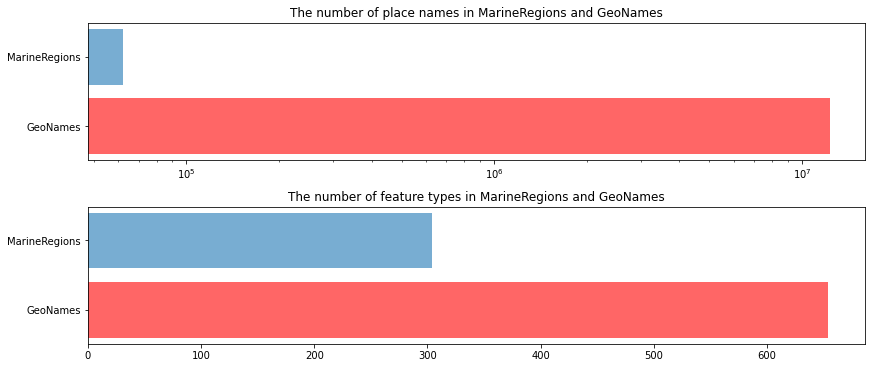

In [ ]:
# compare the number of features
fig, ax = plt.subplots(2,1, figsize = (12, 5), constrained_layout = True)

# place name count
ax[0].barh(['GeoNames'], [12325112], color ='r',alpha = 0.6)
ax[0].barh(['MarineRegions'], [62297],alpha = 0.6)
ax[0].set_xscale('log')
ax[0].set_title('The number of place names in MarineRegions and GeoNames')

# feature type count
ax[1].barh(['GeoNames'], [len(geonames.feature.unique())], color ='r',alpha = 0.6)
ax[1].barh(['MarineRegions'], [len(marine_regions.Placetype.unique())],alpha = 0.6)
ax[1].set_title('The number of feature types in MarineRegions and GeoNames')

Text(0.5, 1.0, 'Most frequent 20 features in GeoNames')

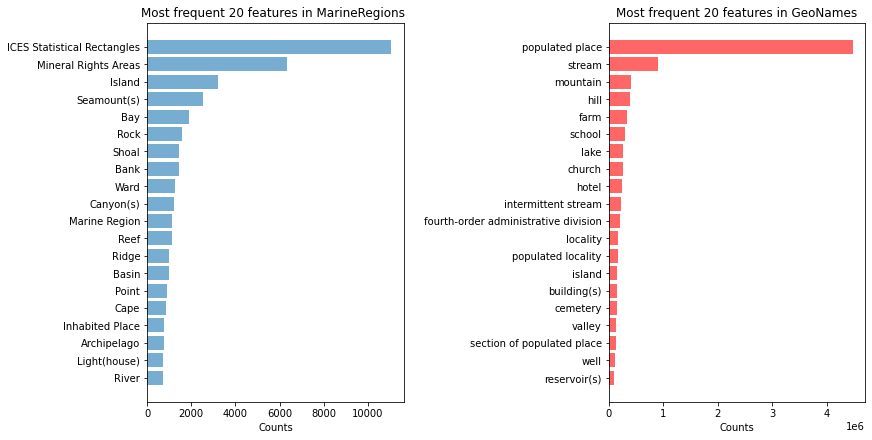

In [ ]:
# compare top 20 from mr and gn respectively

# sort values descendingly by counts
mr_top20 = mr_top20.sort_values(by=['mr_counts'])
gn_top20 = gn_top20.sort_values(by=['gn_counts'])

fig, ax = plt.subplots(1,2,figsize = (12, 6), constrained_layout = True) # subplot 2 rows,1 column

# Marine Regions top 20 features
ax[0].barh(mr_top20['Placetype'].tolist(), mr_top20['mr_counts'].tolist(), alpha = 0.6)
ax[0].set_xlabel('Counts')
ax[0].set_title('Most frequent 20 features in MarineRegions ')

# geonames top 20 features
ax[1].barh(gn_top20['feature'].tolist(), gn_top20['gn_counts'].tolist(), color = 'r', alpha = 0.6)
ax[1].set_xlabel('Counts')
ax[1].set_title('Most frequent 20 features in GeoNames')

# result: 
         #there is no overlap of top features between the two gazetteers.
         # in the topGeoNames top features, there is few maritime features
# next step: 
         # take the MarineRegions top features as benchmarek
         # find corresponding features in GeoNames


In [ ]:
#  from marineregion to 20 features, find corresponding ones in GeoNames 

# function to find the features
def check_feature(feature):
  mr = marine_regions[marine_regions['Placetype']== feature]
  gn = pd.merge(geonames, mr, left_on='name', right_on='locality',how="inner", sort=True)
  return gn.feature.unique()

# e.g.: 'Archipelago' in MarineRegions should be 'islands' in GeoNames. 
  # semantically, except for 'island', other features are not reasonable. 
  # However, 'island' in GeoNames should be 'Island' in MarineRegions
check_feature('Archipelago')

array(['island', 'airfield', 'islands', 'populated place', nan, 'hotel',
       'point', 'seat of a first-order administrative division', 'region',
       'cape', 'inlet', 'estuary', 'bay', 'canal', 'reef',
       'dependent political entity', 'rocks',
       'section of populated place', 'populated locality',
       'seat of a third-order administrative division', 'stream',
       'mountain', 'hill', 'airport',
       'fourth-order administrative division', 'mine(s)', 'building(s)',
       'triangulation station', 'locality', 'park', 'railroad station',
       'seat of a second-order administrative division',
       'intermittent reservoir', 'intermittent stream', 'reservoir(s)',
       'ranch(es)', 'boundary marker', 'independent political entity',
       'populated places', 'nunataks', 'area'], dtype=object)

In [ ]:
# repeat the previous step for all 20 featuresmatching, result is shown below
mr_gn_top_features = pd.read_csv('mr_gn_top_features.csv')

# mr_gn_top_features = mr_gn_top_features.sort_values(by=['mr_counts'])
mr_gn_top_features = pd.merge(mr_gn_top_features, mr_top, left_on ='mr_placetype', right_on ='Placetype',how = 'left')

# calculate the features counts of GeoNames
gn_counts = [0, # ICES Statistical Rectangles
             0, # Mineral Rights Areas
             int(gn_top[gn_top.feature=='island'].gn_counts), # island
             int(gn_top[gn_top.feature=='seamounts'].gn_counts) + int(gn_top[gn_top.feature=='seamount'].gn_counts), # seamount, seamounts
             int(gn_top[gn_top.feature=='bay'].gn_counts) + int(gn_top[gn_top.feature=='bays'].gn_counts), # bay
             int(gn_top[gn_top.feature=='rock'].gn_counts) + int(gn_top[gn_top.feature=='rocks'].gn_counts),
             int(gn_top[gn_top.feature=='shoal'].gn_counts) + int(gn_top[gn_top.feature=='shoals'].gn_counts) + int(gn_top[gn_top.feature=='cove(s)'].gn_counts),
             int(gn_top[gn_top.feature=='bank'].gn_counts) + int(gn_top[gn_top.feature=='banks'].gn_counts),
             int(gn_top[gn_top.feature=='spur'].gn_counts) + int(gn_top[gn_top.feature=='continental rise'].gn_counts),
             int(gn_top[gn_top.feature=='canyon'].gn_counts) + int(gn_top[gn_top.feature=='canyons'].gn_counts),
             int(gn_top[gn_top.feature=='reef'].gn_counts) + int(gn_top[gn_top.feature=='reefs'].gn_counts),
             0, # marine region
             int(gn_top[gn_top.feature=='ridge'].gn_counts) + int(gn_top[gn_top.feature=='ridges'].gn_counts),
             int(gn_top[gn_top.feature=='basin'].gn_counts) + int(gn_top[gn_top.feature=='deep'].gn_counts),
             int(gn_top[gn_top.feature=='point'].gn_counts) + int(gn_top[gn_top.feature=='points'].gn_counts),
             int(gn_top[gn_top.feature=='cape'].gn_counts),
             int(gn_top[gn_top.feature=='populated place'].gn_counts),
             int(gn_top[gn_top.feature=='islands'].gn_counts),
             int(gn_top[gn_top.feature=='lighthouse'].gn_counts),
             int(gn_top[gn_top.feature=='stream'].gn_counts)] 

mr_gn_top_features['gn_counts'] = gn_counts # add the column with the geonames place counts

mr_gn_top_features = mr_gn_top_features[['mr_placetype','mr_counts','gn_features','gn_counts']]
mr_gn_top_features

,mr_placetype,mr_counts,gn_features,gn_counts
0,ICES Statistical Rectangles,11074,na_ICES Statistical Rectangles,0
1,Mineral Rights Areas,6351,na_Mineral Rights Areas,0
2,Island,3217,island,155622
3,Seamount(s),2511,"seamounts, seamount",1661
4,Bay,1912,"bay, bays",50726
5,Rock,1599,"rock, rocks",34912
6,Shoal,1459,"shoal, shoals,cove(s)",24790
7,Bank,1438,"bank, banks",2386
8,Ward,1278,"spur, continental rise",96
9,Canyon(s),1230,"canyon, canyons",4479


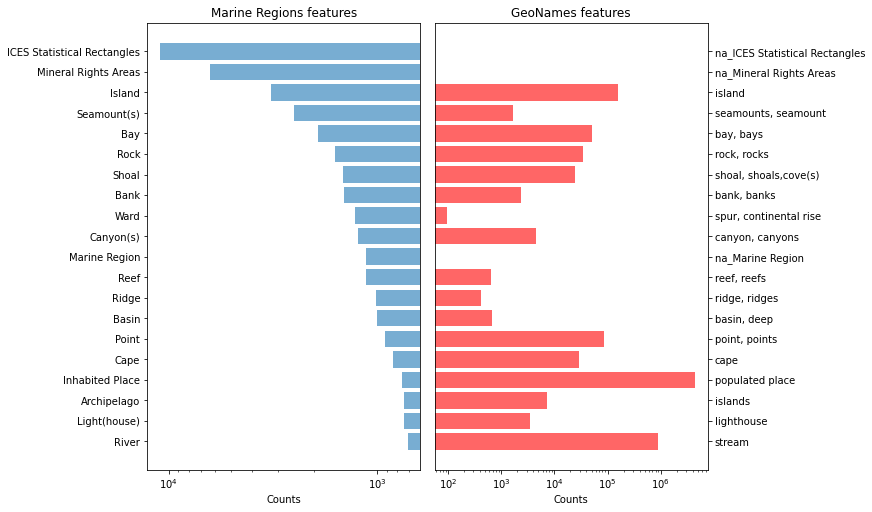

In [ ]:
# visualize the feature counts

mr_gn_top_features = mr_gn_top_features.sort_values(by=['mr_counts'],ascending=True) # sort values descendingly by counts

fig, ax = plt.subplots(1,2,figsize = (12, 7), constrained_layout = True) # subplot 2 rows,1 column

# plot marine regions top features
ax[0].barh(mr_gn_top_features['mr_placetype'].tolist(), mr_gn_top_features['mr_counts'].tolist(), alpha = 0.6)
# ax[0].set_ylabel('Placetype in MarineRegions')
ax[0].set_xlabel('Counts')
ax[0].set_xscale("log")
ax[0].set_title('Marine Regions features')

# plot these top features in geonames
ax[1].barh(mr_gn_top_features['gn_features'].tolist(), mr_gn_top_features['gn_counts'].tolist(), color='r', alpha = 0.6)
# ax[1].set_ylabel('Feature Code in GeoNames')
ax[1].set_xlabel('Counts')
ax[1].set_xscale("log") # log scale 
ax[1].set_title('GeoNames features')

ax[0].invert_xaxis() # reverse x axis
ax[1].yaxis.tick_right() # change position of text


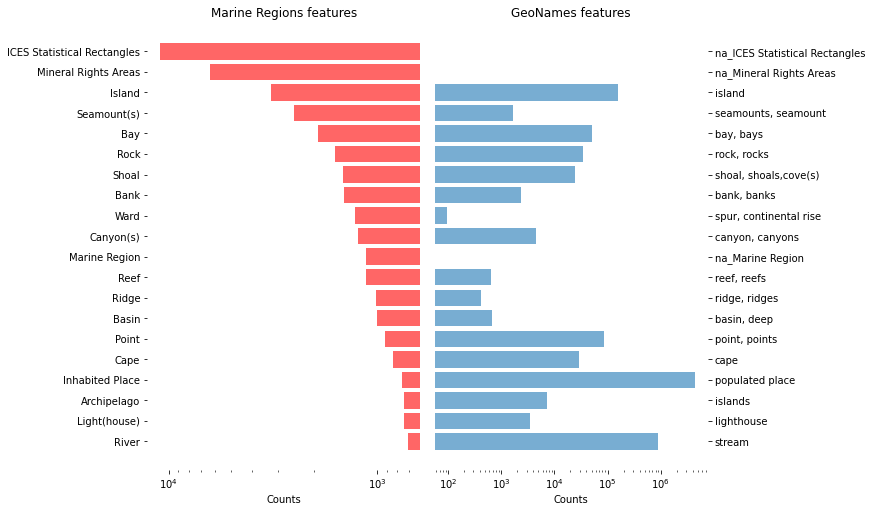

In [ ]:
#mr_gn_top_features = mr_gn_top_features.iloc[15:18,:]

fig, ax = plt.subplots(1, 2, figsize = (12, 7), constrained_layout = True) # subplot 2 rows,1 column
# plot marine regions top features
ax[0].barh(mr_gn_top_features['mr_placetype'].tolist(), mr_gn_top_features['mr_counts'].tolist(), color='r', alpha = 0.6)
ax[0].invert_xaxis()
ax[0].set_xlabel('Counts')
ax[0].set_xscale("log")
ax[0].set_title('Marine Regions features')

# plot these top features in geonames
ax[1].barh(mr_gn_top_features['gn_features'].tolist(), mr_gn_top_features['gn_counts'].tolist(), alpha = 0.6)
ax[1].yaxis.tick_right()
ax[1].set_xlabel('Counts')
ax[1].set_xscale("log") # log scale 
ax[1].set_title('GeoNames features')

# delete boundary line
for i in range(2):
  ax[i].spines['top'].set_visible(False)
  ax[i].spines['right'].set_visible(False)
  ax[i].spines['bottom'].set_visible(False)
  ax[i].spines['left'].set_visible(False)

# All places. Coordinates to list 
# Features. Coordinates to list in dictionary

In [ ]:
# make a list of all the points

# GeoNames
df = geonames
lat = df.latitude.tolist()
lon = df.longitude.tolist()

geonames_points = []
for i in range(len(df)):
    geonames_points.append([lat[i],lon[i]])

# MarinRegions
df = marine_regions
lat = df.decimalLatitude.tolist()
lon = df.decimalLongitude.tolist()

marineregions_points = []
for i in range(len(df)):
    marineregions_points.append([lat[i],lon[i]])


12325112

In [ ]:
#make dictionary for points in each feature

# marine regions
features = mr_gn_top_features.mr_placetype.tolist()
marine_regions_dic = {}

for f in features:
  mr_temp = marine_regions[marine_regions['Placetype']== f]
  lat = mr_temp.decimalLatitude.tolist() # list of latitude
  lon = mr_temp.decimalLongitude.tolist() # list of longitude
  points = [] # all points in a list
  for i in range(len(mr_temp)):
    points.append([lat[i],lon[i]])
  marine_regions_dic[f]= points


In [ ]:
# geonames
# merge features from MarinRegions to GeoNames
top_features2 = pd.read_csv('top_features2.csv')
geonames_selected = pd.merge(geonames, top_features2, how="left",left_on='feature code',right_on='gn_feature_code')

# delete irrelavante records
geonames_selected = geonames_selected[pd.isna(geonames_selected['mr_placetype']) == False]
geonames_selected

# write coordinates to dic
features = mr_gn_top_features.mr_placetype.tolist()
geonames_dic = {}

for f in features:
  gn_temp = geonames_selected[geonames_selected['mr_placetype']== f]
  lat = gn_temp.latitude	.tolist() # list of latitude
  lon = gn_temp.longitude.tolist() # list of longitude
  points = [] # all points in a list
  for i in range(len(gn_temp)):
    points.append([lat[i],lon[i]])
  geonames_dic[f]= points

In [ ]:
# write to jason

with open('geonames_all_points.json', 'w') as f:
    json.dump(marineregions_points, f)
with open('marine_all_points.json', 'w') as f:
    json.dump(geonames_points, f)

with open('geonames_dic.json', 'w') as f:
    json.dump(marine_regions_dic, f)
with open('marine_regions_dic.json', 'w') as f:
    json.dump(marine_regions_dic, f)

# Calculate bandwideth (search radius)

In [ ]:
# function to calculate bandwidth 
import math

def bandWidth(df_temp):
    df_temp
    x = df_temp.UTMx.to_numpy()
    y = df_temp.UTMy.to_numpy()

    # std of x y coordinates
    x = df_temp.UTMx.to_numpy()
    y = df_temp.UTMy.to_numpy()
    Std_x = np.std(x)
    Std_y = np.std(y)

    # calculation of band width
    s = 0.5 *(Std_x+Std_y)

    bd = s * (math.pow(len(x), -1/6)) /1000 #bandwidth in km

    return bd

In [ ]:
# transform latitude longitude to meter
from pyproj import Proj

# marine_regions
# load df
df = marine_regions

lat = df.decimalLatitude.to_numpy()
lon = df.decimalLongitude.to_numpy()

# preprocessing to transfer longitude +180 to its equivalent -180
mask = df['decimalLongitude'] == 180 # a boolean mask of where lon == 180
df.loc[mask, 'decimalLongitude'] = -180 # set 180 to -180

# formulate zone & hemisphere info
df['zone'] = ((lon // 6) + 31).astype(int)
df['southern hemisphere'] = lat < 0
df['UTMx'] = np.zeros(df.shape[0])
df['UTMy'] = np.zeros(df.shape[0])

# UTM lists
UTMx = []
UTMy = []

for i in range(df.shape[0]):
    # parameter formulation
    proj = '+ proj=utm '
    zone = '+zone = ' + str(df.iloc[i, :]['zone'])
    south = ' +south ' if df.iloc[i, :]['southern hemisphere'] else ' '
    ellp = '+ellps=WGS84'
    # myProj = Proj('+proj=utm +zone=10 +ellps=WGS84', preserve_units=False) # define crs
    myProj = Proj(proj + zone + south + ellp, preserve_units=False) # define crs
    lon_temp = df.iloc[i, :]['decimalLongitude'] # longitude of current loc
    lat_temp = df.iloc[i, :]['decimalLatitude'] # latitude of current loc
    # projection
    UTMx_temp, UTMy_temp = myProj(lon_temp, lat_temp) # convert gcs to pcs

    # append to UTM lists
    UTMx.append(UTMx_temp)
    UTMy.append(UTMy_temp)

df['UTMx'] = UTMx
df['UTMy'] = UTMy

In [ ]:
# transform latitude longitude to meter
from pyproj import Proj

# marine_regions
df = geonames
lat = df.latitude.to_numpy()
lon = df.longitude.to_numpy()

# preprocessing to transfer longitude +180 to its equivalent -180
mask = df['longitude'] == 180 # a boolean mask of where lon == 180
df.loc[mask, 'longitude'] = -180 # set 180 to -180

# formulate zone & hemisphere info
df['zone'] = ((lon // 6) + 31).astype(int)
df['southern hemisphere'] = lat < 0
df['UTMx'] = np.zeros(df.shape[0])
df['UTMy'] = np.zeros(df.shape[0])

# UTM lists
UTMx = []
UTMy = []

for i in range(df.shape[0]):
    # parameter formulation
    proj = '+ proj=utm '
    zone = '+zone = ' + str(df.iloc[i, :]['zone'])
    south = ' +south ' if df.iloc[i, :]['southern hemisphere'] else ' '
    ellp = '+ellps=WGS84'
    # myProj = Proj('+proj=utm +zone=10 +ellps=WGS84', preserve_units=False) # define crs
    myProj = Proj(proj + zone + south + ellp, preserve_units=False) # define crs
    lon_temp = df.iloc[i, :]['longitude'] # longitude of current loc
    lat_temp = df.iloc[i, :]['latitude'] # latitude of current loc
    # projection
    UTMx_temp, UTMy_temp = myProj(lon_temp, lat_temp) # convert gcs to pcs

    # append to UTM lists
    UTMx.append(UTMx_temp)
    UTMy.append(UTMy_temp)

df['UTMx'] = UTMx
df['UTMy'] = UTMy

In [ ]:
# as projection transformation takes a long time, bandwideth calculation result organized below
pd.read_csv('search radius.csv')

,MarineRegions_feature,mr_bandwidth(km),GeoNames_feature,gn_bandwidth(km)
0,all,189.859621,all,77.059430
1,Island,341.346076,island,161.801838
2,Seamount(s),341.375736,"seamounts, seamount",384.065163
3,Bay,280.207059,"bay, bays",181.127967
